# Clustering Recency, Frequency, and Monetary (RFM)

We're going to explore patterns in the data, then use k-means, bayesian gaussian mixture, and agglomerative clustering to cluster the data - visually selecting the best method.  Then we are going to explore what that tells us about our customers.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from scipy.stats import mannwhitneyu

from statsmodels.stats.weightstats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

#### First let's load and clean the data...

In [4]:
home_dir = '/home/jupyter/data_science_challenges/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')



In [5]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

df = df.loc[df.Country == 'United Kingdom']

### Convenience Functions

In [6]:
def transform_and_scale(data, reverse_field=None):
    """
    Purpose: Transform data using Boxcox and StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox and StandardScaler...')
    if reverse_field:
        print(f'With Reverse Field(s): {reverse_field}')
    #print(data.head())
    if not isinstance(data,pd.core.frame.DataFrame):
        data = data.to_frame()
    for c in data.columns:
        print(f"Transforming {c}...")
        v,l = boxcox(abs(data[c]+.0000000001))
        data[c] = v
        
        print(f"Scaling {c}...")
        scaler = MinMaxScaler()
        data[c] = scaler.fit_transform(np.array(data[c].to_frame()))
        
        if reverse_field:
            print(f"Reversing {c}...")
            data[c] = 1 - data[c] 
           
    #print(data.head())
    return data

def dist_plots(data, col):
    plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots(2,1)
    sns.boxplot(data[col], ax=ax[0], orient='h')
    sns.violinplot(data[col], ax=ax[1], orient='h')
    plt.tight_layout()
    plt.show()
    
def get_iqr(data,col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    return iqr

    
def plot_cluster_scatter(data, cols, label, n, transform_and_scale_data=True, algorithm='PCA'): 
    
    """
    Purpose: Plot clusters in a scatterplot
    Input:
        data - a dataframe
        cols - a string or list of columns
        label - a string used to label the plot
        n - number of clusters
        transform_and_scale_data - boolean.  Default is True.  If False, data is not transformed via boxcox transform or scaled via StandardScaler
        algorithm - string.  Default is PCA, but can also be TSNE or LDA
    Output:
        a scatterplot
    """    
    plt.figure(figsize=(10, 5))
    
    if transform_and_scale_data:
        #Scales and Transforms data
        data[cols] = transform_and_scale(data[cols])
    
    if algorithm.lower() == 'pca':
    
        from sklearn.decomposition import PCA
    
        pca = PCA()
    
        results = pd.DataFrame(pca.fit_transform(data[cols]))

        results.columns = [f'PC{i+1}' for i in range(results.shape[1])]

        data['PC1'] = results['PC1']

        data['PC2'] = results['PC2']
        
        sns.scatterplot(x='PC1',y='PC2', hue=label, palette=sns.color_palette("hls",10),data=data)
        
    if re.sub('-', '', algorithm.lower()) == 'tsne':
        
        from sklearn.manifold import TSNE
        
        tSNE=TSNE()
        
        results=tSNE.fit_transform(data)
        
        data['X'] = results[:,0]

        data['Y'] = results[:,1]
    
        sns.scatterplot(x='X',y='Y', hue=label, palette=sns.color_palette("hls",10),data=data)
        
    if algorithm.lower() == 'lda':
        
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        
        lda = LinearDiscriminantAnalysis()
        
        results = lda.fit_transform(data[cols], data[label])
        
        data['LD1'] = results[:,0]

        data['LD2'] = results[:,1]
        
        sns.scatterplot(x='LD1',y='LD2', hue=label, palette=sns.color_palette("hls",10),data=data)
        
def plot_cluster_graph(data, transform_and_scale_data=True):
    
    """
    Purpose: Plot cluster graph
    Input: 
        data - a dataframe column
        transform_and_scale - boolean.  Default is True.  If False, data is not transformed via boxcox transform or scaled via StandardScaler
    Output: A scree plot that allows us to determine optimal number of clusters
    """

    print('Plotting cluster graph...')
    
    #Sum of Sqared Errors
    sse = {}

    if transform_and_scale_data:
        #Scales and Transforms data
        data = transform_and_scale(data)

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(data)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 5))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()


### RECENCY, FREQUENCY, MONETARY ANALYSIS 
Objective is to find the RFM for each customer to determing Low, Medium and High Value Customers

In [7]:
# We drop returns.
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()

#### Recency

In [8]:
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()

In [9]:
# We drop returns.
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days 
r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'min'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)


#### Checking Resulting Distribution

<Figure size 1000x500 with 0 Axes>

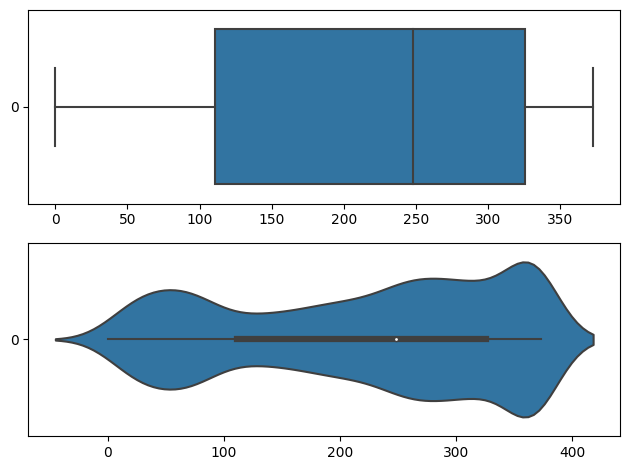

In [10]:
dist_plots(r_df, 'Recency')

In [11]:
# get interquartile range
get_iqr(r_df, 'Recency')
iqrX1_5= get_iqr(r_df, 'Recency') * 1.5

# find column between
r_df.Recency.between(r_df.Recency.quantile(0.25) - iqrX1_5,\
                     r_df.Recency.quantile(0.75) + iqrX1_5).value_counts()


Recency
True    3921
Name: count, dtype: int64

Takeaways: Substantial right skew, even before normalization.  Will explore the number of outliers and strip if necessary

Scree plot shows 3 or 4 clusters would be optimal

#### Frequency
We are going to use the formula:
Frequency = 1 / Median( Time between Purchases)

In [12]:
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()
f_df = new_df[['InvoiceDate','CustomerID']].drop_duplicates().sort_values(by=['CustomerID','InvoiceDate'], ascending=True).reset_index(drop=True)

#Creating difference between invoice dates per person
f_df['Offset'] = f_df.groupby(['CustomerID'])['InvoiceDate'].diff().dt.seconds

# Creating Count per user
f_df = f_df.merge(\
    f_df.groupby(['CustomerID']).agg(Count = ('InvoiceDate', 'count')).reset_index()\
           ,on=['CustomerID'], how='inner')

# Finding folks who only had one interaction and giving them an Offset that is differenced from the latest day in the dataset
f_df.loc[f_df.Count == 1, 'Offset'] = (f_df.InvoiceDate.max() - f_df.InvoiceDate).dt.seconds

# Dropping the first occurance of a invoicedate.  Not needed to make agg.
f_df = f_df.loc[~(f_df.Offset.isna())]

f_df = f_df.groupby(['CustomerID']).agg(Frequency = ('Offset','median')).reset_index()

#f_df['FrequencyHertz'] = 1/f_df.Frequency

<Figure size 1000x500 with 0 Axes>

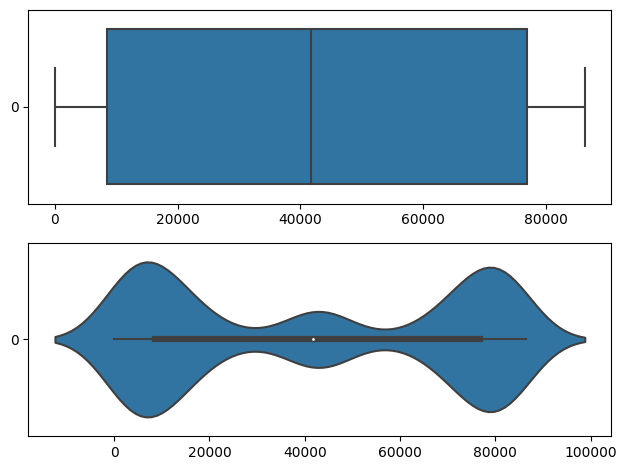

In [13]:
dist_plots(f_df, 'Frequency')

In [14]:
# get interquartile range
get_iqr(f_df, 'Frequency')
iqrX1_5= get_iqr(f_df, 'Frequency') * 1.5

f_df.Frequency.between(f_df.Frequency.quantile(0.25) - iqrX1_5,\
                     f_df.Frequency.quantile(0.75) + iqrX1_5).value_counts()

Frequency
True    3921
Name: count, dtype: int64

#### Monetary

In [15]:
# We use DF instead of new_df here because we want to penalize users for their returns.
m_df = df[['CustomerID','Revenue']].groupby('CustomerID').agg(Revenue = ('Revenue', 'sum')).reset_index()

<Figure size 1000x500 with 0 Axes>

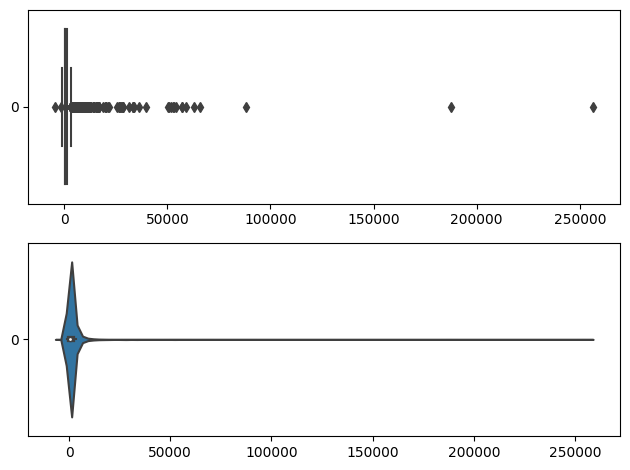

In [16]:
dist_plots(m_df, 'Revenue')

In [17]:
# get interquartile range
get_iqr(m_df, 'Revenue')
iqrX1_5= get_iqr(m_df, 'Revenue') * 1.5

m_df.Revenue.between(m_df.Revenue.quantile(0.25) - iqrX1_5,\
                     m_df.Revenue.quantile(0.75) + iqrX1_5).value_counts()

Revenue
True     3567
False     383
Name: count, dtype: int64

In [18]:
final_df = r_df.merge(f_df, on='CustomerID', how='inner').merge(m_df, on='CustomerID', how='inner')

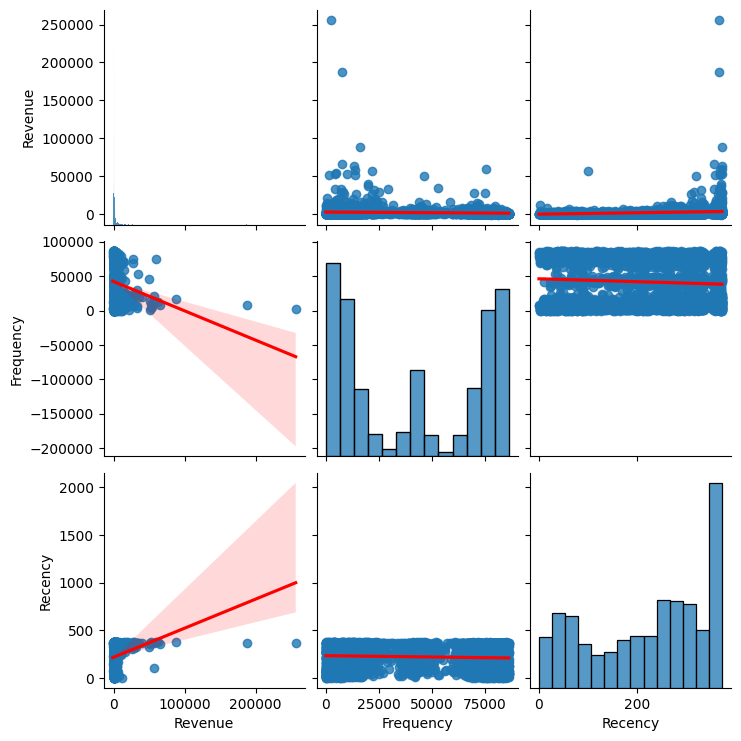

In [19]:
sns.pairplot(final_df[['Revenue', 'Frequency', 'Recency']], palette=sns.color_palette("hls",10), kind='reg', plot_kws={'line_kws':{'color':'red'}})

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


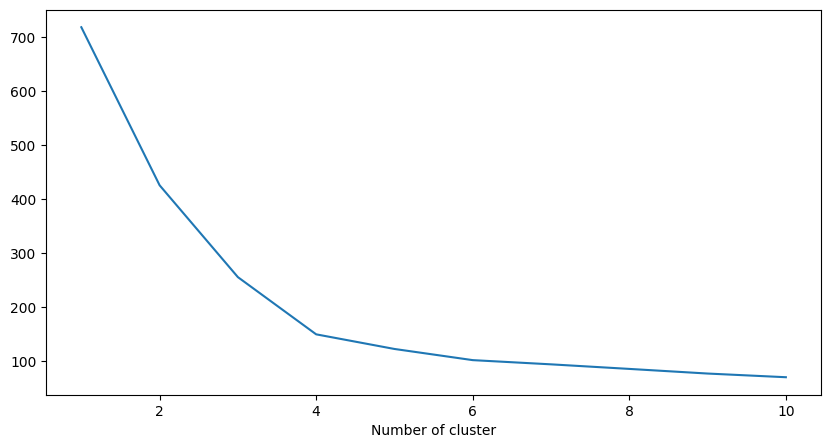

In [20]:
plot_cluster_graph(final_df[['Revenue', 'Frequency', 'Recency']])

#### Takeaway: 
We have 3 clusters

Now, let's scale and transform the data.

In [21]:
xformed_rfm = final_df.copy()
xformed_rfm[['Recency', 'Frequency', 'Revenue']] = transform_and_scale(final_df[['Recency', 'Frequency', 'Revenue']], reverse_field=['Recency', 'Frequency'])

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency', 'Frequency']
Transforming Recency...
Scaling Recency...
Reversing Recency...
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Transforming Revenue...
Scaling Revenue...
Reversing Revenue...


Lets Check for correlations.

<Axes: >

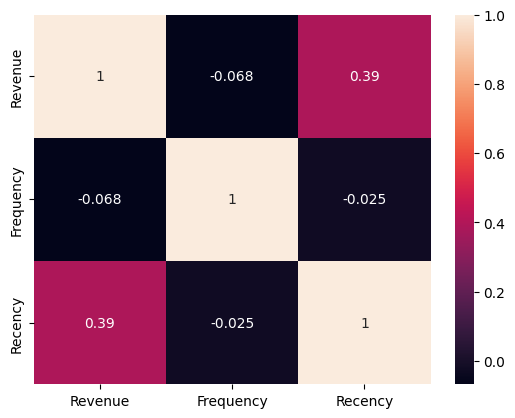

In [22]:
sns.heatmap(xformed_rfm[['Revenue', 'Frequency', 'Recency']].corr() ,annot=True)

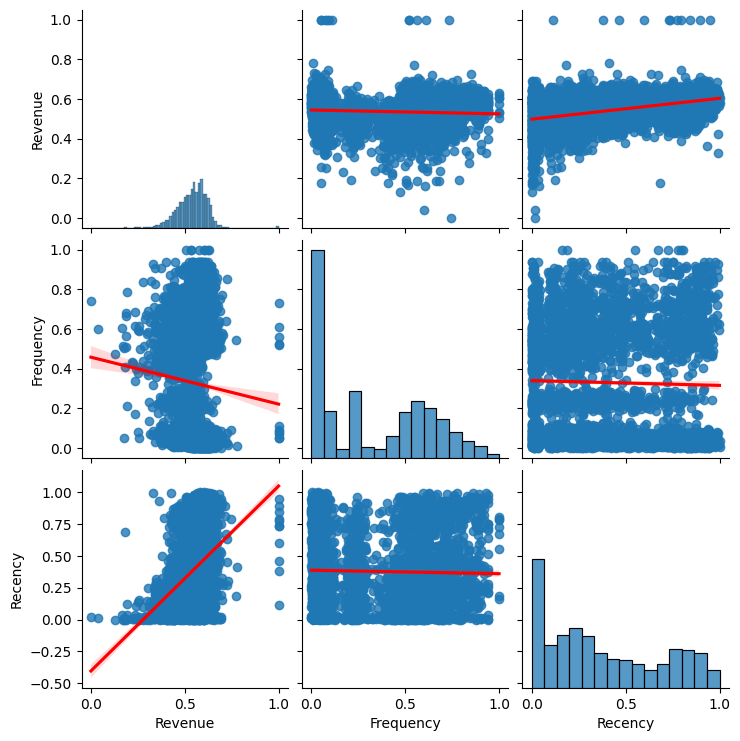

In [23]:
sns.pairplot(xformed_rfm[['Revenue', 'Frequency', 'Recency']], palette=sns.color_palette("hls",10), kind='reg', plot_kws={'line_kws':{'color':'red'}})

Lets look at how well it maps to different dimensionality reduction plots!

### K-Means

In [212]:
score_dict = {}

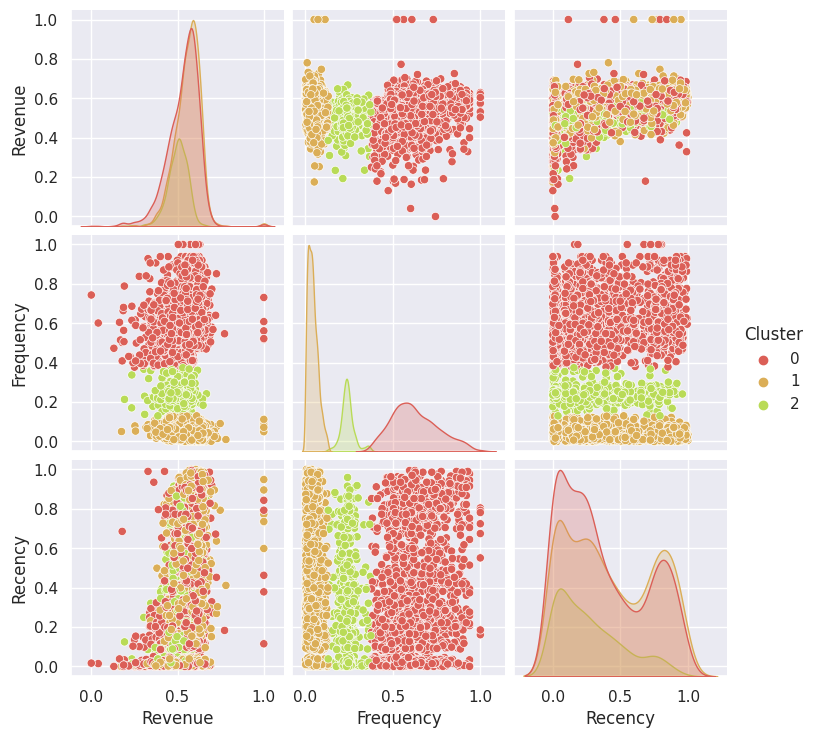

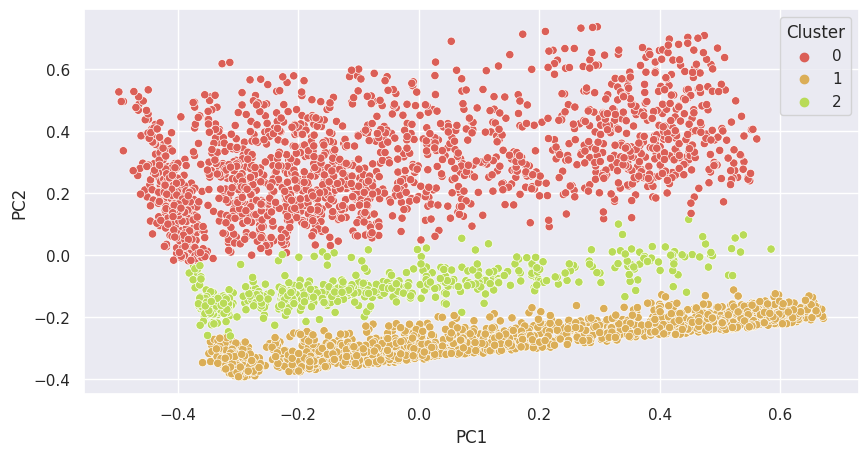

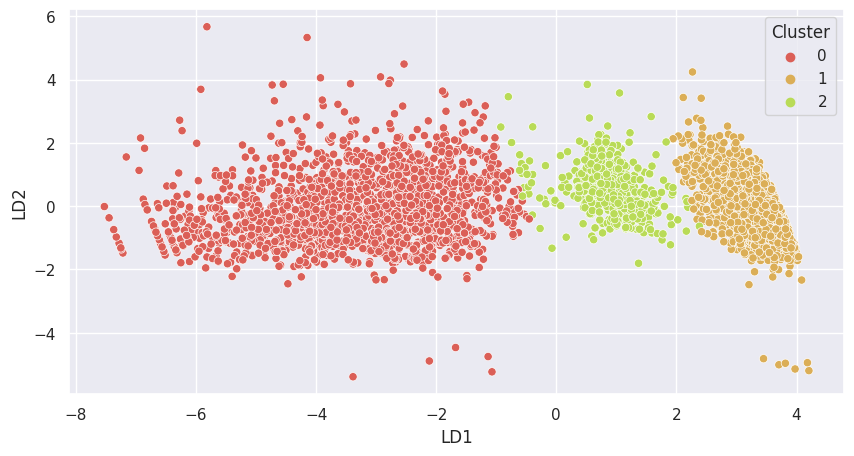

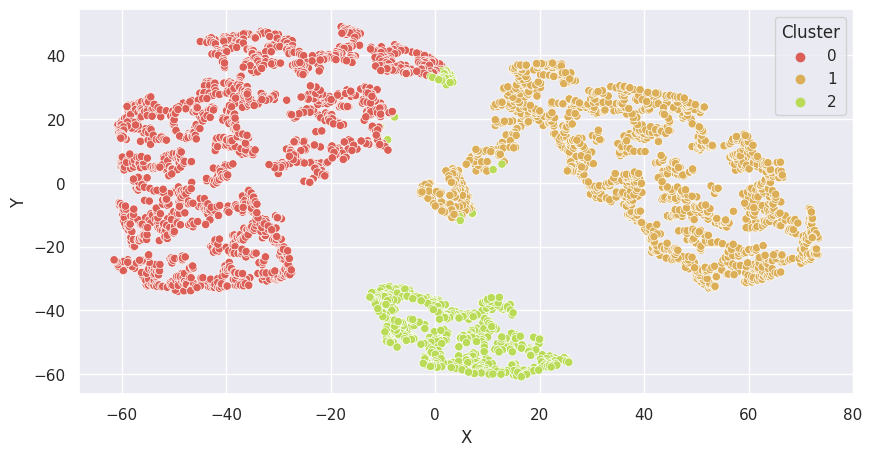

In [240]:
# Instantiate and fit the model
cluster_no = 3
kmeans = KMeans(n_clusters=cluster_no, random_state=0)

# Create and plot a prediction dataframe
pred_df = xformed_rfm.copy()

# Fit the model and get clusters
pred_df['Cluster'] = kmeans.fit_predict(final_df[['Recency', 'Frequency', 'Revenue']])

#Get cluster labels and create a score dict to store validation scores
score_dict['kmeans'] = {'silhouette_score': metrics.silhouette_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'], metric='euclidean')
                       , 'calinski_harabasz_score': metrics.calinski_harabasz_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'])}

#plot the clusters
sns.pairplot(data =pred_df, vars = ['Revenue', 'Frequency', 'Recency'], hue='Cluster', palette=sns.color_palette("hls",10))
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='pca')
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='lda')
plot_cluster_scatter(data=final_df.assign(Cluster = pred_df['Cluster']).copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='tsne')

#### Gaussian Mixture Model

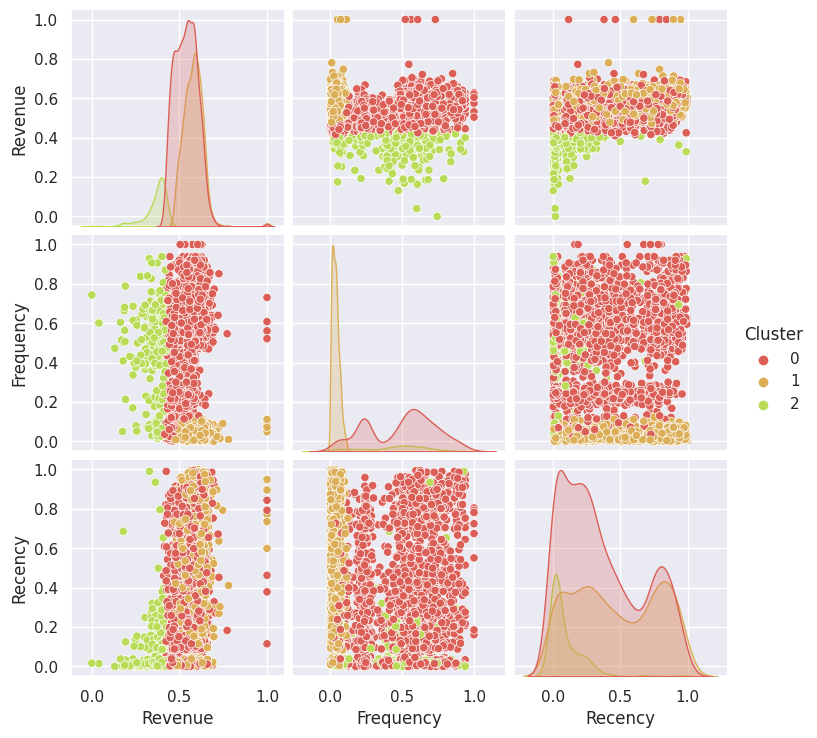

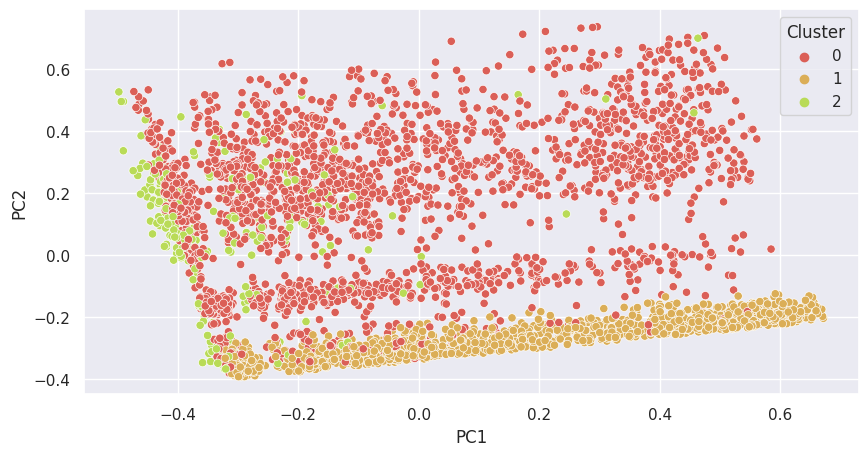

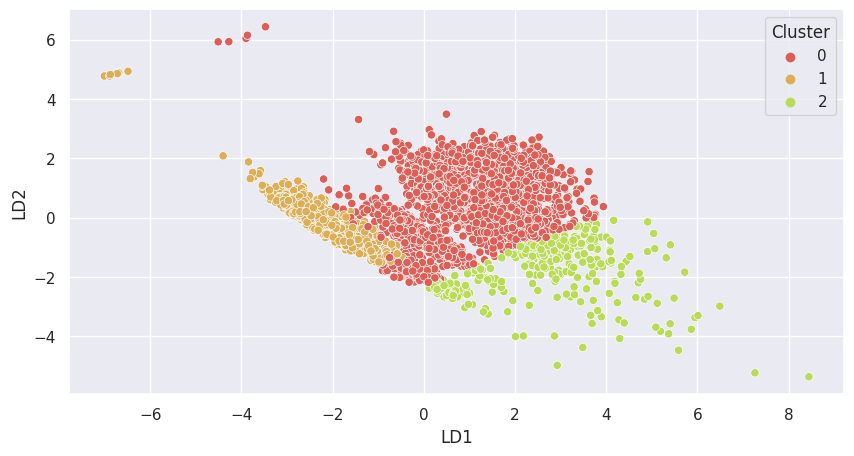

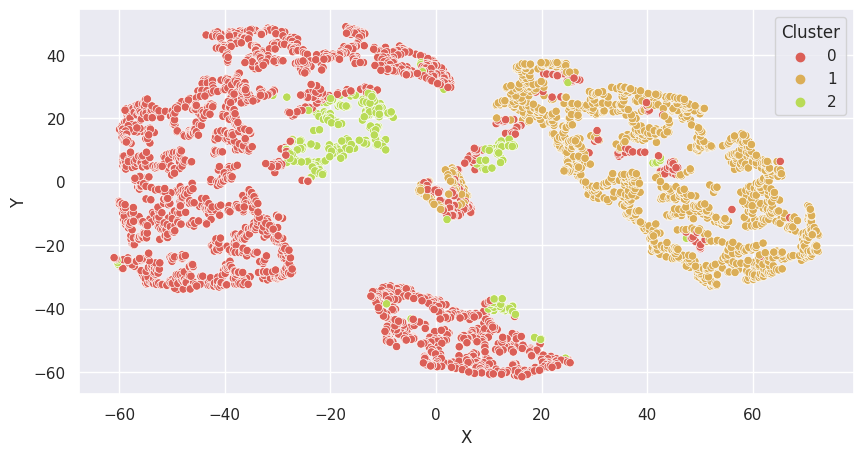

In [241]:
# Instantiate and fit the model
cluster_no = 3
bgm = BayesianGaussianMixture(n_components=3, random_state=0, n_init=20, covariance_type='full')

# Create and plot a prediction dataframe
pred_df = xformed_rfm.copy()
pred_df['Cluster'] = bgm.fit_predict(final_df[['Recency', 'Frequency', 'Revenue']])


#Get cluster labels and create a score dict to store validation scores
score_dict['gaussian'] = {'silhouette_score': metrics.silhouette_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'], metric='euclidean')
                       , 'calinski_harabasz_score': metrics.calinski_harabasz_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'])}

#Plot the clusters
sns.pairplot(data =pred_df, vars = ['Revenue', 'Frequency', 'Recency'], hue='Cluster', palette=sns.color_palette("hls",10))
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='pca')
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='lda')
plot_cluster_scatter(data=final_df.assign(Cluster = pred_df['Cluster']).copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='tsne')

#### Agglomerative Clustering

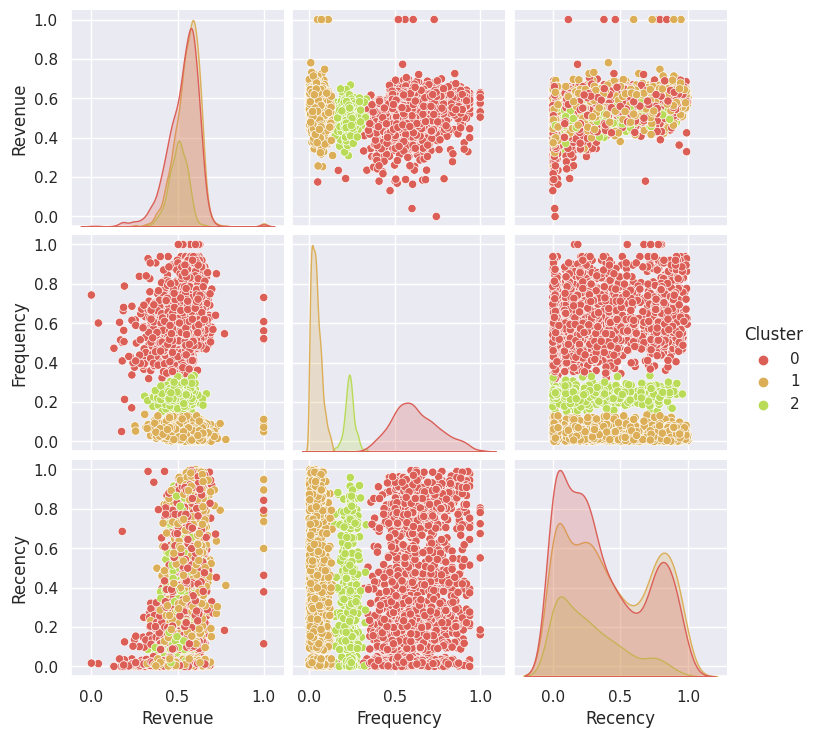

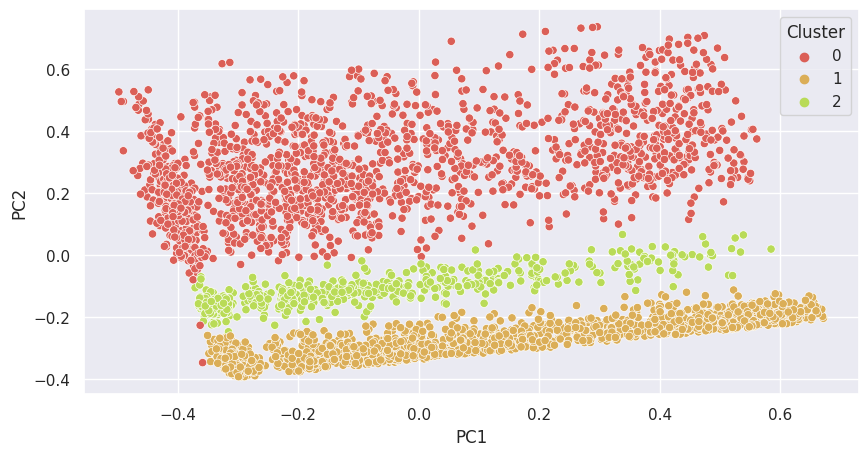

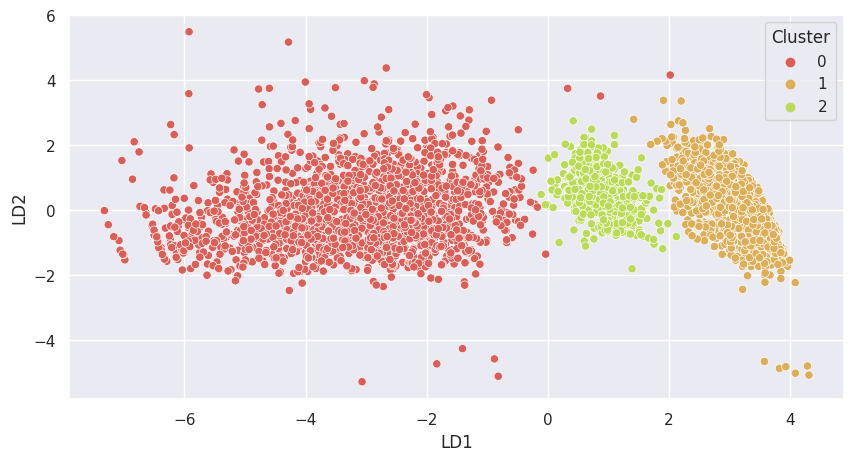

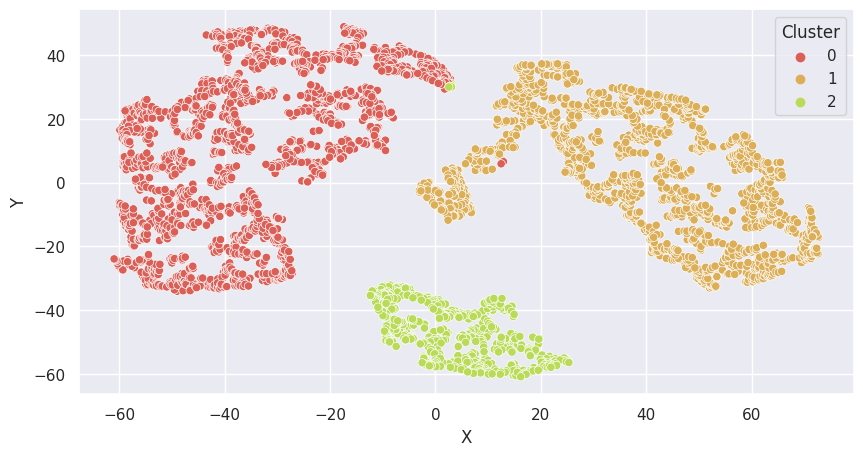

In [242]:
# Instantiate and fit the model
cluster_no = 3
agc = AgglomerativeClustering(n_clusters=cluster_no)

# Create and plot a prediction dataframe
pred_df = xformed_rfm.copy()
pred_df['Cluster'] = agc.fit_predict(final_df[['Recency', 'Frequency', 'Revenue']])

#Get cluster labels and create a score dict to store validation scores
score_dict['agglomerative'] = {'silhouette_score': metrics.silhouette_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'], metric='euclidean')
                       , 'calinski_harabasz_score': metrics.calinski_harabasz_score(final_df[['Recency', 'Frequency', 'Revenue']], pred_df['Cluster'])}

#Plot the clusters
sns.pairplot(data =pred_df, vars = ['Revenue', 'Frequency', 'Recency'], hue='Cluster', palette=sns.color_palette("hls",10))
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='pca')
plot_cluster_scatter(data=pred_df.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='lda')
plot_cluster_scatter(data=final_df.assign(Cluster = pred_df['Cluster']).copy(), cols=['Revenue', 'Frequency', 'Recency'], label='Cluster', n=cluster_no, transform_and_scale_data=False, algorithm='tsne')

### Selected Clustering Algorithms
Agglomerative Clustering seems to perform the best upon visual inspection using PCA, LDA and TSNE. HOWEVER...

In [244]:
pd.DataFrame(score_dict).T

silhouette_score  calinski_harabasz_score
kmeans                 0.761487             26003.100012
gaussian               0.402075              4107.890687
agglomerative          0.757540             24998.213274

Given the silhouette score and calinski harabasz ratio,K-Means seems to have a slight edge over Agglomerative Clustering in this excerise.

### Analysis of Cluster Features
Lets look at the clusters created via kmeans clustering to determine what each cluster is like.

In [245]:
test_df = final_df.copy()
test_df['Cluster'] = kmeans.fit_predict(test_df[['Recency', 'Frequency', 'Revenue']])

In [246]:
test_df.groupby('Cluster').Recency.describe()

count        mean         std   min     25%    50%    75%    max
Cluster                                                                   
0        1746.0  226.049828  118.077423   1.0  115.25  256.0  327.0  373.0
1        1602.0  204.592385  121.525245   0.0   80.00  219.0  312.0  373.0
2         573.0  261.750436   96.127059  10.0  203.00  282.0  353.0  373.0

In [247]:
test_df.groupby('Cluster').Frequency.describe()

count          mean          std      min      25%      50%  \
Cluster                                                                 
0        1746.0   8314.140893  5965.104445      0.0   3360.0   7620.0   
1        1602.0  77612.940075  5854.698282  60060.0  73777.5  78540.0   
2         573.0  42539.790576  5556.723952  25440.0  40230.0  42720.0   

             75%      max  
Cluster                    
0        12240.0  25200.0  
1        82320.0  86340.0  
2        45300.0  60060.0

In [248]:
test_df.groupby('Cluster').Revenue.describe()

count         mean          std      min     25%       50%  \
Cluster                                                                
0        1746.0  2307.944864  9381.292059  -451.42  294.26   626.890   
1        1602.0   990.799427  2197.653121 -1165.30  215.54   448.885   
2         573.0  1988.253997  3351.142066    62.43  700.63  1251.840   

               75%        max  
Cluster                        
0        1788.1925  256438.49  
1        1034.2100   59284.19  
2        2216.0600   50415.49

In [249]:
test_df[['Recency', 'Frequency', 'Revenue']].describe()

Recency     Frequency        Revenue
count  3921.000000   3921.000000    3921.000000
mean    222.500128  41629.104820    1723.081345
std     118.103068  32526.664663    6570.412011
min       0.000000      0.000000   -1165.300000
25%     111.000000   8460.000000     288.600000
50%     248.000000  41730.000000     630.840000
75%     326.000000  76860.000000    1524.400000
max     373.000000  86340.000000  256438.490000

### T-Tests:
Let's run some t-tests to see if the clusters are different.

In [250]:
cols = ['Recency', 'Frequency', 'Revenue']
clusters = [0, 1, 2]

for col in cols:
    for cluster in clusters:
        x_arr =test_df.loc[(test_df['Cluster'] == cluster)][col]
        s_arr =test_df[col]
        tt = ttest_ind(x_arr, s_arr)
        print(f"For Column {col}, Cluster {cluster}, p-value = {tt[1]}.  The Difference betwwen means ({s_arr.mean() - x_arr.mean()}) is {'not significant' if tt[1] > .05 else 'significant'}.")

For Column Recency, Cluster 0, p-value = 0.2961929446602402.  The Difference betwwen means (-3.5497006602039676) is not significant.
For Column Recency, Cluster 1, p-value = 4.097220518015549e-07.  The Difference betwwen means (17.907742999139373) is significant.
For Column Recency, Cluster 2, p-value = 3.695701899304944e-14.  The Difference betwwen means (-39.25030878168431) is significant.
For Column Frequency, Cluster 0, p-value = 0.0.  The Difference betwwen means (33314.963926728145) is significant.
For Column Frequency, Cluster 1, p-value = 0.0.  The Difference betwwen means (-35983.83525470743) is significant.
For Column Frequency, Cluster 2, p-value = 0.5037104792543847.  The Difference betwwen means (-910.6857557172989) is not significant.
For Column Revenue, Cluster 0, p-value = 0.007102929663537203.  The Difference betwwen means (-584.8635186233964) is significant.
For Column Revenue, Cluster 1, p-value = 1.3118834532647033e-05.  The Difference betwwen means (732.28191809874

### Mann Whitney U Test:
We've got some serious skew in our data.  Let's look at the Mann-Whitney Test to leverage 
the robustness of medians.

In [251]:
cols = ['Recency', 'Frequency', 'Revenue']
clusters = [0, 1, 2]

for col in cols:
    for cluster in clusters:
        x_arr =test_df.loc[(test_df['Cluster'] == cluster)][col]
        s_arr =test_df[col]
        mw = mannwhitneyu(x_arr, s_arr)
        print(f"For Column {col}, Cluster {cluster}, p-value = {mw[1]}.  The Difference betwwen medians ({s_arr.median() - x_arr.median()}) is {'not significant' if mw[1] > .05 else 'significant'}.")

For Column Recency, Cluster 0, p-value = 0.23300121706853183.  The Difference betwwen medians (-8.0) is not significant.
For Column Recency, Cluster 1, p-value = 6.162165152250794e-07.  The Difference betwwen medians (29.0) is significant.
For Column Recency, Cluster 2, p-value = 5.043648805363878e-12.  The Difference betwwen medians (-34.0) is significant.
For Column Frequency, Cluster 0, p-value = 1.8524639499336605e-244.  The Difference betwwen medians (34110.0) is significant.
For Column Frequency, Cluster 1, p-value = 1.777051211587184e-261.  The Difference betwwen medians (-36810.0) is significant.
For Column Frequency, Cluster 2, p-value = 0.15499017890479888.  The Difference betwwen medians (-990.0) is not significant.
For Column Revenue, Cluster 0, p-value = 0.19214319365265176.  The Difference betwwen medians (3.9500000000000455) is not significant.
For Column Revenue, Cluster 1, p-value = 5.661185612983242e-18.  The Difference betwwen medians (181.95500000000004) is signific

### Takeaway:
* Cluster 0 has average recency, low frequency, and middling revenue.
* Cluster 1 has low recency, high frequency, and low revenue.
* Cluster 2 has high recency, average frequency, and high revenue.

Each cluster descibes a different type of customer.  

* Customer type 0 is relatively infrequent customer who spends marginally more than the median. We can call these relatively inactive customers.*

* Customer type 1 is a relatively new customer that has visited more often than the median, but spent significantly less.  We can call these new customers.

* Customer type 2 is an older customer that has visited more often than the median, and spent significantly more.  We can call these loyal and valued customers*.

### Lets explore trends by Cluster

In [252]:
work_df = df.merge(test_df, on='CustomerID', how='left').dropna()

In [253]:
agg_df = work_df.groupby(['Cluster','Description']).agg(Quantity = ('Quantity','sum'), Revenue = ('Revenue_x','sum'), Median_Revenue = ('Revenue_y','median'), Frequency = ('Frequency','median')).reset_index().sort_values(['Cluster','Quantity'], ascending=False)

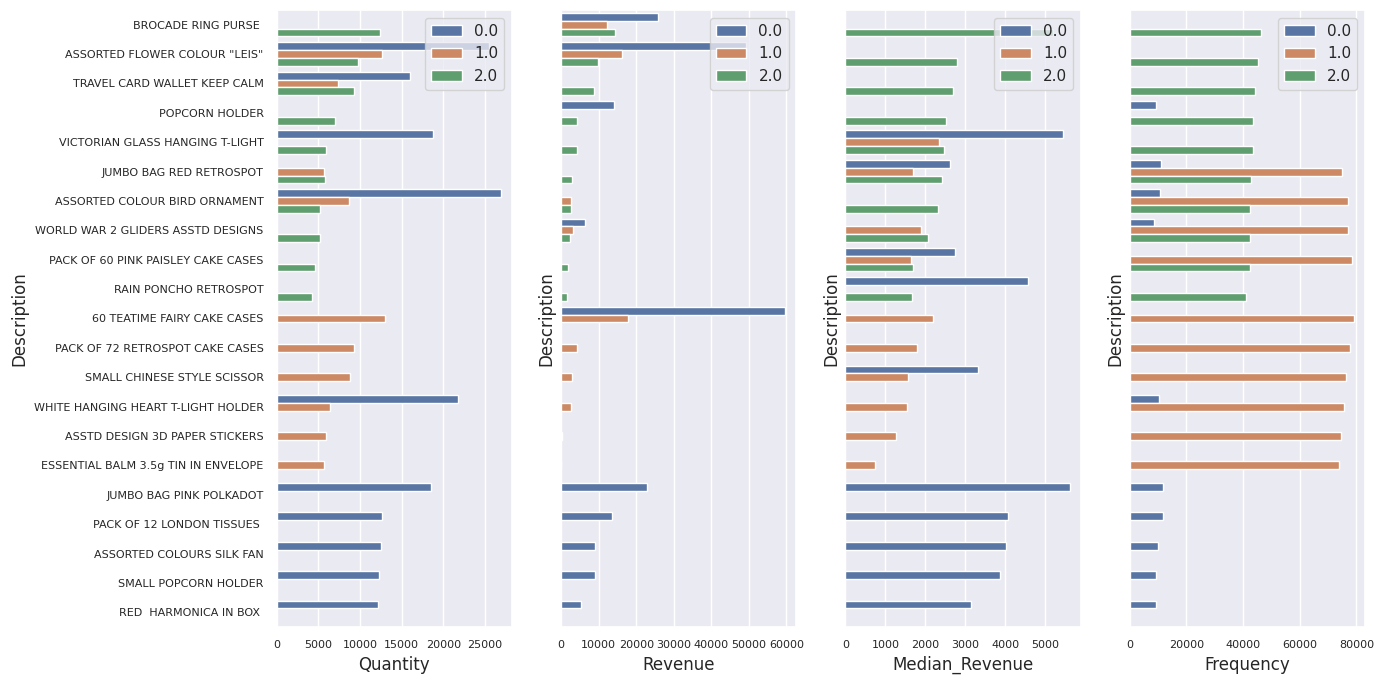

In [254]:
fig, ax = plt.subplots(1, 4, sharey=True,figsize=(14, 7))

for i,c in enumerate(['Quantity', 'Revenue', 'Median_Revenue', 'Frequency']):
    g = sns.barplot(agg_df.groupby(['Cluster']).head(10).sort_values(['Cluster',c], ascending=False)\
                , y="Description", x=c, hue="Cluster", orient="h", ax=ax[i],)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].legend(loc="upper right")
#fig.legend([ax[0],ax[1],ax[2],ax[3]], labels=agg_df.Cluster.unique().tolist(),loc="upper right") 
fig.tight_layout()